# Hangig Four Bar Linkage

## Introduction
This is example 9.7 from the textbook "Dynamics" of Roithmayr and Hodges (Cambridge University Press, 2016). It is a hanging" four bar linkage driven by weight forces. All bars have the same length 2*L. The fourth bar is the ground, where 2*L equals the horizontal distance of the bearings. The intention of this notebook is to show how auxilary speed in Kane's method can be used to derive constrained forces. Here the task is to determine the horizontal restraint force at point P. The following figure shoes a sketch of the system.

![](./4BarLinkage.png)


In [16]:
from sympy import symbols, Matrix, tan, cos, trigsimp
from sympy.physics.mechanics import *
from sympy import Dummy, lambdify, diff
from numpy import array, hstack, zeros, ones, linspace, pi, empty
from numpy.linalg import solve
from scipy.integrate import odeint
import matplotlib.pyplot as plt

## Variables
The system has one degree of freedom (i.e. q1), with u1 as its derivative. ua is the auxilary speed (horizontal speed at point P) used to derive the restraint force. Additional variables are described by comments. Note: Though the bars have equal shapes, masses and mass moments of inertia are initally treated by different symbols.

In [17]:
q1 = dynamicsymbols('q1') # generalized coordinate
u1, ua = dynamicsymbols('u1 ua') # generalized speeds

g, t = symbols('g t') # gravity and time symbols
L = symbols('L') # length symbol
mA, mB, mC = symbols('mA mB mC') # mass symbols
I_A, I_B, I_C = symbols('I_A I_B I_C') # mass symbols

## Basic Frames
Definition of the inertial frame and the local frame of bar A, which is rotated by q1.

In [18]:
# frames
frame_n = ReferenceFrame('frame_n') # inertial frame
frame_e = frame_n.orientnew('frame_e', 'axis', [q1, frame_n.z]) # local frame

## Reference Point P
This point is normally fixed. Since the horizontal bearing force is to be determined, its horizontal speed is set equal to ua. However, this point does not have any degree of freedom, since ua will finally be set equal to zero.

In [19]:
# reference point P
P = Point('P')
P.set_vel(frame_n, ua*frame_n.x)

## Center of Gravity of Bar A
The center of gravity of bar A (cgA) is defined relative to point P.

In [20]:
# center point of bar A
cgA = P.locatenew('cgA',-L*frame_e.y)
cgA.set_vel(frame_e, 0)
cgA.v2pt_theory(P, frame_n, frame_e)
print('velocity of cg of bar A')
vprint(cgA.vel(frame_n))

velocity of cg of bar A
ua*frame_n.x + L*q1'*frame_e.x


## Center of Gravity of Bar B
In the origional system the center of gravity of bar B (cgB) has the same coordinate (q1) and genaralized speed (u1) as bar B, however, it rotates about point S instead of point P. Here the effect of the auxiliary speed ua has to be superposed, assuming an infinitesimal small deviation from the original configuration defined by q1 (see sketch below, however, the effect of ua is exaggerated). Thus the inclination of bar C is assumed such small, that the superposed horizontal velocity at point R practically equals that of point Q, which is ua (if q1 is fixed). On the other hand the superposed speed at point R must be a circumferrential speed, denoted as uB, since bar B can only rotated about point S. The angle between ua and uB is q1, since uB is perpendicular to bar B and ua is parallel to bar C and thus it is in direction x of the inertial frame by assumption. uy is the velocity in direction y of the inertial frame giving uB, when added as a vector to ua. Therefore, uy is perpendicular to bar C. This gives an equation, from which the superposed rotational speed of bar B, resulting in uB, can be derived. The center of gravity of bar B is geometrically defined relative to point S (frame_e), The effect of the auxiliary speed ua is introduced by the additional local frame_Ba, which has an angular speed relative to frame_e due to ua. 

![](./4BarLinkageEffect_ua.png)


In [21]:
# center point of bar B
S = P.locatenew('S',2*L*frame_n.x) # reference point 
S.set_vel(frame_n, 0)
frame_Ba = ReferenceFrame('frame_Ba') # auxiliary frame
frame_Ba.set_ang_vel(frame_e, ua/(2*L*cos(q1))*frame_e.z) # rotation due to ua
cgB = S.locatenew('cgB',-L*frame_e.y)
cgB.set_vel(frame_Ba, 0)
cgB.v2pt_theory(S, frame_n, frame_Ba)
print('velocity of cg of bar B')
vprint(cgB.vel(frame_Ba))
vprint(cgB.vel(frame_n))

velocity of cg of bar B
0
L*(q1' + ua/(2*L*cos(q1)))*frame_e.x


## Center of Gravity of Bar C
Though the inclination of bar C due to ua is assumed as infinitesimal small, the vertical velocity uy of R due to ua is not. It depends on q1. Since the vertical speed at point Q due to ua is zero, uy is finally the effect of an angular speed of bar C (rotating about point Q). As with bar B the angular speed is incorperated by an additional local frame (here frame_Ca). Its angular speed is defined relative to the inertial frame, since bar C does not rotate in the original configuration. 

In [22]:
# center point of bar C
Q = P.locatenew('Q',-2*L*frame_e.y) # intermediate point Q
Q.set_vel(frame_e, 0)
Q.v2pt_theory(P, frame_n, frame_e)
frame_Ca = ReferenceFrame('frame_Ca') # auxiliary frame
frame_Ca.set_ang_vel(frame_n, ua*tan(q1)/(2*L)*frame_n.z) # rotation due to ua
cgC = Q.locatenew('cgC',L*frame_n.x)
cgC.set_vel(frame_Ca,0)
cgC.v2pt_theory(Q, frame_n, frame_Ca)
print('velocity of point Q')
vprint(Q.vel(frame_n))
print('velocity of cg of bar C')
vprint(cgC.vel(frame_n))

velocity of point Q
ua*frame_n.x + 2*L*q1'*frame_e.x
velocity of cg of bar C
ua*frame_n.x + ua*tan(q1)/2*frame_n.y + 2*L*q1'*frame_e.x


## Definition of the bodies
The full mass moment of inertia matrix has to be transferred. However, here only the elements, which are really needed are defined correctly, the other elements are dummy values for convenience.
Though all bars have the same mass and length, the inertia matrix would be the same. Anyway, the matrices are hasndled individually.
The frames of the bodies must be the local frames conmsidering the effect of ua.

In [23]:
# bodies
fakI = 1/12*(2*L)*(2*L) # fakI*m gives moment of inertia
I_A = inertia(frame_e,mA*fakI,0,mA*fakI) # only relevant inertias are right
I_B = inertia(frame_e,mB*fakI,0,mB*fakI)
I_C = inertia(frame_n,mC*fakI,0,mC*fakI)

barA = Body('barA', cgA, mA, frame_e, I_A)
barB = Body('barB', cgB, mB, frame_Ba, I_B)
barC = Body('barC', cgC, mC, frame_Ca, I_C)

## Definition of the system
The definition of the system is somehow standard. Here only weight forces have to be considered, which are applied at the centers of gravity of the bars.
The solution is printed using "trigsimp" in order to simplify the mathematical expression. Thus the results can be directly compared with those of the textbook.

In [24]:
# system lists
kin_odes = [] # list to hold kinematic ODE's
bodies = [] # list to hold particles
forces = [] # list to hold applied forces

kin_odes.append(q1.diff(t) - u1) # kinematic ODE: dq_i/dt-u_i=0

bodies.append(barA)
bodies.append(barB)
bodies.append(barC)

barA.apply_force(-barA.mass*g*frame_n.y,barA.masscenter)
barB.apply_force(-barB.mass*g*frame_n.y,barB.masscenter)
barC.apply_force(-barC.mass*g*frame_n.y,barC.masscenter)

for item in barA.loads:
    forces.append(item)

for item in barB.loads:
    forces.append(item)

for item in barC.loads:
    forces.append(item)

q = [q1]
u = [u1]
uaux = [ua]

kane = KanesMethod(frame_n, q_ind=q, u_ind=u, kd_eqs=kin_odes, u_auxiliary=uaux)# generate EoM's:
fr, frstar = kane.kanes_equations(bodies, forces) # fr + frstar = 0

print('system mass matrix:')
vprint(trigsimp(kane.mass_matrix))
print(' ')
print('system force matrix:')
vprint(trigsimp(kane.forcing))
print(' ')
print('auxiliary Kane’s equation:')
vprint(trigsimp(kane.auxiliary_eqs))
print(' ')

system mass matrix:
Matrix([[1.33333333333333*L**2*mA + 1.33333333333333*L**2*mB + 4*L**2*mC]])
 
system force matrix:
Matrix([[-L*g*(mA + mB + 2*mC)*sin(q1)]])
 
auxiliary Kane’s equation:
Matrix([[L*mA*u1**2*sin(q1) - L*mA*cos(q1)*u1' - 0.666666666666667*L*mB*u1'/cos(q1) - L*mC*(cos(q1) + 1/cos(q1))*u1' + L*mC*u1**2*sin(q1) - g*mB*tan(q1)/2 - g*mC*tan(q1)/2]])
 


## Built numeric system 
Next the system equations are built numerically after importing required modules. In order to determine the reaction force the acceleration will be needed, which is not stored autimatically by the solver. Therfore, a new dynamic symbol is defined and in order to include this symbol an additional set of lists is added. 

In [25]:
# source: https://www.moorepants.info/blog/npendulum.html
# alternative source: http://deebuls.github.io/differential-drive-part-1.html

u1d = dynamicsymbols('u1d') # acceleration as new variable

# Parameter definitions starting with gravity and the common length
parameters = [g, L, mA, mB, mC]
parameter_vals = [9.81, 1.0, 1.0, 2.0, 3.0] #Values of constants

# Create a list of dynamic symbols for simulation
dynamic =  q + u
dummy_symbols = [Dummy() for i in dynamic]  # create a dummy symbol for each variable
dummy_dict = dict(zip(dynamic, dummy_symbols))
kindiff_dict = kane.kindiffdict() # get the solved kinematical differential equations
# Substitute into the mass matrix 
M = kane.mass_matrix_full.subs(kindiff_dict).subs(dummy_dict)
# Substitute into the forcing vector
F = kane.forcing_full.subs(kindiff_dict).subs(dummy_dict)

# Create a list of dynamic symbols for calculation of reaction force
AuxEqu = msubs(kane.auxiliary_eqs, {u1.diff(): u1d}) # replaces derivative by a variable
dynamic.append(u1d) # add additional acceleration variable
dummy_symbols2 = [Dummy() for i in dynamic]  # create a dummy symbol for each variable
dummy_dict2 = dict(zip(dynamic, dummy_symbols2))
Freac = AuxEqu.subs(kindiff_dict).subs(dummy_dict2)

# Create a callable function to evaluate the mass matrix and the forcing vector
M_func = lambdify(dummy_symbols + parameters, M)
F_func = lambdify(dummy_symbols + parameters, F)
Freac_func = lambdify(dummy_symbols2 + parameters, Freac)

## Additional functions
Two function are defined in order to determine the required additional additional results from the solution of the equation of motion.
right_hand_side: determines the acceleration; it is a simply a recurrent solution of a linear equation following from the equation of motion (which is solved for acceleration)
reactions: determines the reaction force acc. to the the auxiliary equation of Kane' equations

In [26]:
def right_hand_side(x, t, args):
    """Returns the derivatives of the states.

    Parameters
    ----------
    x : ndarray, shape(2 * (n + 1))
        The current state vector.
    t : float
        The current time.
    args : ndarray
        The constants.

    Returns
    -------
    dx : ndarray, shape(2 * (n + 1))
        The derivative of the state.
    
    """
    arguments = hstack((x, args))     # states, input, and parameters
    dx = array(solve(M_func(*arguments), # solving for the derivatives
        F_func(*arguments))).T[0]

    return dx


In [27]:
def reactions(x, t, args):
    """Returns the reaction forces acc. to the auxiliary equations at time t.

    Parameters
    ----------
    x : ndarray
        The current state vector plus acceleration vector.
    t : float
        The current time.
    args : ndarray
        The constants.

    Returns
    -------
    freac : ndarray, 
        The reaction forces acc. to the auxiliary equations
    
    """
    u1d = right_hand_side(x, t, args=parameter_vals) # determine acceleration as solution of the rhs
    arguments = hstack((x, array([u1d[1]]), args))  # states, input, and parameters
    freac = Freac_func(*arguments) # solving for the derivatives
 
    return freac

## Integrating the equation of motion
Next the equation of motion is integrated numerically. The initial solution is q1=30deg and u1=0. The time span is set from 0 to 10s. The textbook gives solutions for 9s and 10s. The number of solution points is set to a quantity giving sufficient resolution for a graphical view.

In [28]:
# Integration of the system
x0 = hstack((pi / 6. * ones(len(q)), zeros(len(u)) )) # Initial conditions, q and u
npts = 201 # number of sample points
t = linspace(0., 10., npts) # time vector
y = odeint(right_hand_side, x0, t, args=(parameter_vals,))    # actual integration

## Check the results
The results are printed every 1s.

In [29]:
# List results for some time points
q_deg = empty([npts])
Reactions = empty([npts])
for i in range(len(t)):
    q_deg[i] = y[i,0]*180/pi
    Reactions[i] = reactions(y[i,:], t[i], args=parameter_vals)[0]

print(' ')
print('solution (t, q1, u1, Fx):')
for i in range(0,201,20):
    print(t[i],q_deg[i],y[i,1],Reactions[i])
print(' ')


 
solution (t, q1, u1, Fx):
0.0 29.999999999999996 0.0 9.203684978719137
1.0 -20.25007936792827 -0.8924324311206865 -8.043943539252936
2.0 -2.8513448363726064 1.2103360354924522 -1.3575828874052431
3.0 24.05114183249253 -0.7214098163829845 8.789477619131151
4.0 -29.470208389831853 -0.22497645068332844 -9.207131045245706
5.0 15.716020125807695 1.0324720342941553 6.737719115959581
6.0 8.448749356129598 -1.1656792050465752 3.915299312202728
7.0 -26.98891928980998 0.5259911776742845 -9.115976148005558
8.0 27.897901650236296 0.4426904732393262 9.169593905673452
9.0 -10.608452085386636 -1.1357587278905015 -4.829076632434633
10.0 -13.735152080892346 1.0784157194217343 -6.045561608408226
 


The textbook gives the following solutions for the last two rows:<br>
q1(9s) = 10.608deg, u1(9s) = -1.1358, Fx=4.829<br>
q1(10s) = -13.736deg & u110s) = 1.0784, Fx=6.046<br>
The results obtained here are in good agreement with the results from the textbook. However, the reactions differ with respect to the sign. From t=0 ist follows, that here Fx is the force of bar A exerted on the joint (i.e. ground). Its negative value is the force exerted on bar A.

## Result plot
The following diagram shows time variations of the variable q1 (in degree) and the reation force.

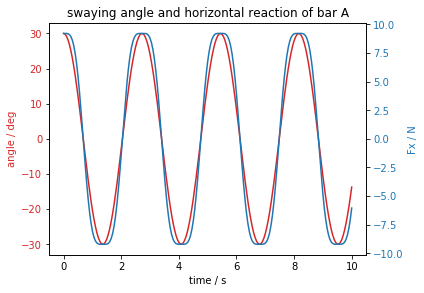

In [30]:
# Plot the results
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time / s')
ax1.set_ylabel('angle / deg', color=color)
ax1.plot(t, q_deg, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Fx / N', color=color)  # we already handled the x-label with ax1
ax2.plot(t, Reactions, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.title('swaying angle and horizontal reaction of bar A')
plt.show()


Since neither damping nor friction is considered, the amplitudes remain constant here.